In [1]:
import time

import pandas as pd
import numpy as np

import nltk
nltk.download('gutenberg')

import tensorflow as tf
keras = tf.keras

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('ggplot')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\aleksander.molak\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


# NLP Concepts #6 - RNNs in practice

## Define helpers

In [2]:
def get_slices(text, slice_len=100):
    
    text_split = text.split(' ')
    
    n_chunks = int(len(text_split) / slice_len)
    current_start_id = 0
    
    slices = []
    
    for i in range(n_chunks + 1):
        current_slice = text_split[current_start_id:current_start_id + slice_len]
        
        if len(current_slice) > 0:
            slices.append(' '.join(current_slice))
        
        current_start_id += slice_len
        
    return slices

## Get and prepare data

In [3]:
# Print corpora and their lengths
for i in nltk.corpus.gutenberg.fileids():
    src = nltk.corpus.gutenberg.words(i)
    print(i, len(src))

austen-emma.txt 192427
austen-persuasion.txt 98171
austen-sense.txt 141576
bible-kjv.txt 1010654
blake-poems.txt 8354
bryant-stories.txt 55563
burgess-busterbrown.txt 18963
carroll-alice.txt 34110
chesterton-ball.txt 96996
chesterton-brown.txt 86063
chesterton-thursday.txt 69213
edgeworth-parents.txt 210663
melville-moby_dick.txt 260819
milton-paradise.txt 96825
shakespeare-caesar.txt 25833
shakespeare-hamlet.txt 37360
shakespeare-macbeth.txt 23140
whitman-leaves.txt 154883


### Join and check lengths

In [4]:
# Shakespeare's "Macbeth"
shkspr = nltk.corpus.gutenberg.words('shakespeare-macbeth.txt')
shkspr_join = ' '.join(shkspr)

len(shkspr)

23140

In [5]:
# Carroll's "Alice's adventures (...)"
carroll = nltk.corpus.gutenberg.words('carroll-alice.txt')[:23140]
carroll_join = ' '.join(carroll)

len(carroll)

23140

### Get slices and generate labels

In [9]:
# Get slices
shkspr_slices = get_slices(shkspr_join, 250)
carroll_slices = get_slices(carroll_join, 250)

In [10]:
len(shkspr_slices), len(carroll_slices)

(93, 93)

In [11]:
# Create X
X = shkspr_slices + carroll_slices

# Create y
y = np.array([0] * 93 + [1] * 93)

### Train test split

In [13]:
# Train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

### Tokenize texts

In [17]:
# Initialize a tokenizer
VOCAB_SIZE = 20000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=VOCAB_SIZE,
    lower=True,  
    oov_token=1
)

In [18]:
# Fit the toknizer
tokenizer.fit_on_texts(X_train)

In [19]:
# Tokenize
X_train_tok = tokenizer.texts_to_sequences(X_train) 
X_test_tok = tokenizer.texts_to_sequences(X_test)

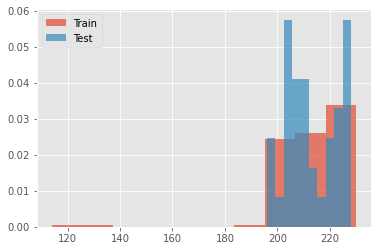

In [20]:
# Plot seq lens
seq_lens_train = [len(seq) for seq in X_train_tok]
seq_lens_test = [len(seq) for seq in X_test_tok]

plt.hist(seq_lens_train, density=True, alpha=.7, label='Train')
plt.hist(seq_lens_test, density=True, alpha=.7, label='Test')

plt.legend()
plt.show()

In [21]:
# Find maxlen
MAXLEN = max([len(x.split(' ')) for x in X_train])

In [23]:
# Pad sequences
X_train_tok_pad = pad_sequences(X_train_tok, maxlen=MAXLEN, padding='post')
X_test_tok_pad = pad_sequences(X_test_tok, maxlen=MAXLEN, padding='post')

## Classification example

In [24]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val, epochs=30, lr=1e-4, verbose=2):
    
    # Compile
    model.compile(loss = 'binary_crossentropy',
                  optimizer = tf.keras.optimizers.Adam(lr),
                  metrics = ['accuracy'])
    
    # Callbacks
    early = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    
    # Time it
    start = time.time()
    
    # Fit 
    history = model.fit(X_train, y_train,
                       validation_data = (X_val, y_val),
                       callbacks = [early],
                       epochs = epochs,
                       verbose = verbose)
    
    # Time it
    training_time = time.time() - start
    
    # Plot learning curve
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.title('Loss')
    
    plt.subplot(122)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.legend()
    plt.title('Accuracy')
    
    plt.show()
    
    # Evaluate
    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    
    print(f'Val. accuracy: {acc}')
    print(f'Training time: {training_time:.02f} seconds')

### Build a simple model

In [29]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(
        input_dim = VOCAB_SIZE,
        output_dim = 100,
        mask_zero = True,
        input_length = MAXLEN),
    
    tf.keras.layers.LSTM(64),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 2,042,305
Trainable params: 2,042,305
Non-trainable params: 0
_________________________________________________________________


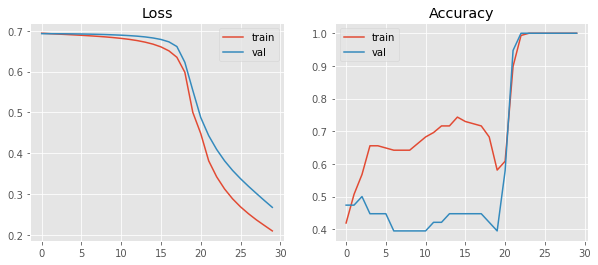

Val. accuracy: 1.0
Training time: 37.44 seconds


In [31]:
train_and_evaluate(model, X_train_tok_pad, y_train, X_test_tok_pad, y_test, verbose=0, epochs=30)

### Build a deeper model

In [32]:
model_2 = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(
        input_dim = VOCAB_SIZE,
        output_dim = 100,
        mask_zero = True,
        input_length = MAXLEN),
    
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(128),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [33]:
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 100)          2000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 250, 64)           42240     
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 2,141,185
Trainable params: 2,141,185
Non-trainable params: 0
_________________________________________________________________


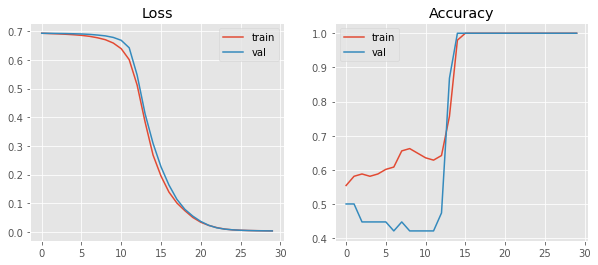

Val. accuracy: 1.0
Training time: 86.53 seconds


In [34]:
train_and_evaluate(model_2, X_train_tok_pad, y_train, X_test_tok_pad, y_test, verbose=0, epochs=30)

## Build a bi-directional model

In [ ]:
model_3 = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(
        input_dim = VOCAB_SIZE,
        output_dim = 100,
        mask_zero = True,
        input_length = MAXLEN),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_3.summary()

In [ ]:
train_and_evaluate(model_3, X_train_tok_pad, y_train, X_test_tok_pad, y_test, verbose=0, epochs=30)

## Build a deep bi-directional model

In [35]:
model_4 = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(
        input_dim = VOCAB_SIZE,
        output_dim = 100,
        mask_zero = True,
        input_length = MAXLEN),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [36]:
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 250, 100)          2000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 250, 128)          84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 2,347,905
Trainable params: 2,347,905
Non-trainable params: 0
_________________________________________________________________


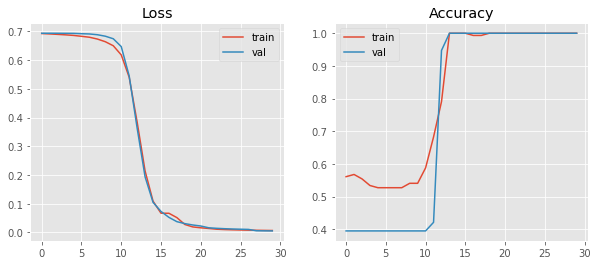

Val. accuracy: 1.0
Training time: 140.63 seconds


In [37]:
train_and_evaluate(model_4, X_train_tok_pad, y_train, X_test_tok_pad, y_test, verbose=0, epochs=30)

## Long distance dependencies - `SimpleRNN()` and `LSTM()`

#### Experiment:

We will put a negative number at the beginnig of a random sequence of positive numbers. We'll manipulate sequence length and check how it affects performance of `SimpleRNN` and `LSTM` in a classification task.

<br>

<img src="https://www.hackingwithswift.com/uploads/matrix.jpg" alt="Numbers" style="width: 400px;"/>



In [45]:
LENGTHS = [10, 20, 50, 200]

In [46]:
def build_dataset(length, n_examples):
    
    X = []
    y = []
    
    for i in range(n_examples):
        class_ = np.random.choice([0, 1])
        
        if class_ == 1:
            row = np.array([-1] + list(np.random.choice(np.arange(0, 1, .01), length - 1)))
        elif class_ == 0:
            row = np.random.choice(np.arange(0, 1, .01), length)
            
        X.append(row)
        y.append(class_)
        
    return np.array(X)[:, :, np.newaxis], np.array(y)

In [47]:
def build_model(rnn_type, len_):
    
    if rnn_type == 'rnn':
        rnn_layer = tf.keras.layers.SimpleRNN
    elif rnn_type == 'lstm':
        rnn_layer = tf.keras.layers.LSTM
    
    model = tf.keras.Sequential([

        rnn_layer(64, input_shape=(len_, 1), return_sequences=True),
        rnn_layer(128),
        
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dropout(.2),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

Buidling dataset of length 10

RNN for 10


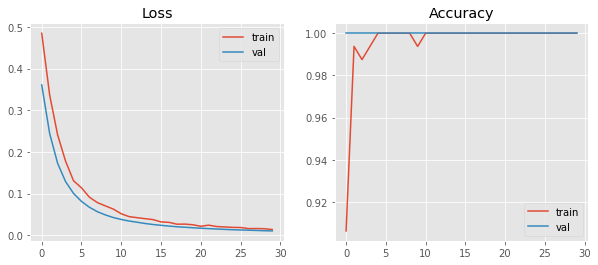

Val. accuracy: 1.0
Training time: 6.10 seconds

LSTM for 10


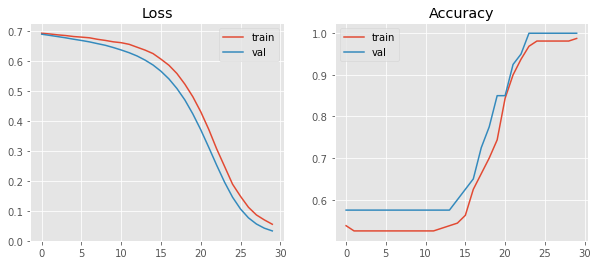

Val. accuracy: 1.0
Training time: 8.22 seconds
Buidling dataset of length 20

RNN for 20


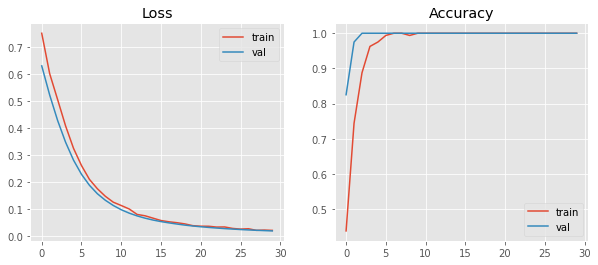

Val. accuracy: 1.0
Training time: 5.50 seconds

LSTM for 20


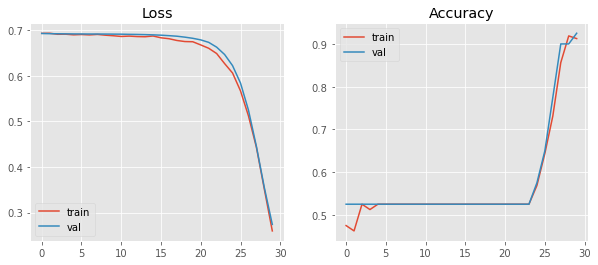

Val. accuracy: 0.925000011920929
Training time: 10.12 seconds
Buidling dataset of length 50

RNN for 50


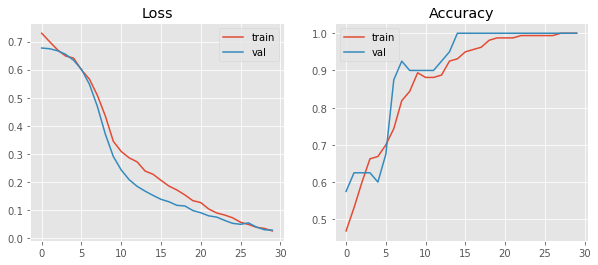

Val. accuracy: 1.0
Training time: 7.15 seconds

LSTM for 50


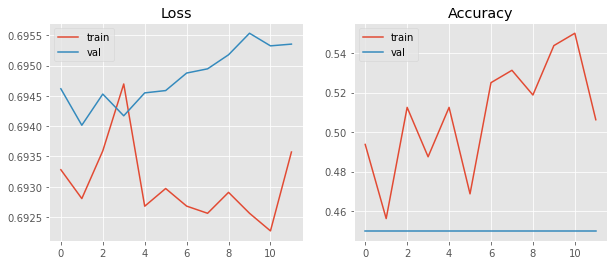

Val. accuracy: 0.44999998807907104
Training time: 8.67 seconds
Buidling dataset of length 200

RNN for 200


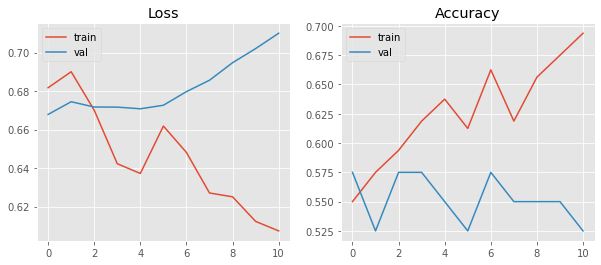

Val. accuracy: 0.574999988079071
Training time: 9.58 seconds

LSTM for 200


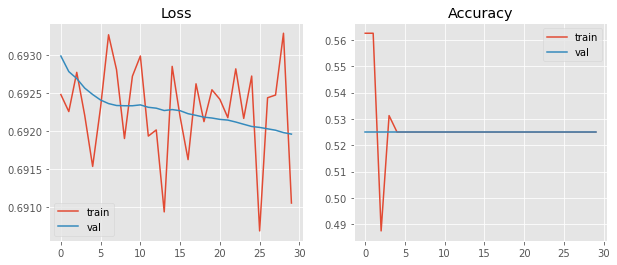

Val. accuracy: 0.5249999761581421
Training time: 41.36 seconds


In [48]:
for len_ in LENGTHS:
    
    # Prep data
    print(f'Buidling dataset of length {len_}')
    X, y = build_dataset(len_, 200)
    
    # Train test split 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    
    # Build models
    rnn_model = build_model('rnn', len_)
    lstm_model = build_model('lstm', len_)
    
    # Train and evaluate
    print(f'\nRNN for {len_}')
    train_and_evaluate(rnn_model, X_train, y_train, X_test, y_test, verbose=0, epochs=30)
    
    print(f'\nLSTM for {len_}')
    train_and_evaluate(lstm_model, X_train, y_train, X_test, y_test, verbose=0, epochs=30)